In [3]:
from src.sec_8k_preprocess import load_8k_filings, parse_8k_filing
from src.CRSP_ITI_FNSPID_merge import process_crsp_iti_fnspid_dataset
import polars as pl
import hvplot.polars
from src.utils.event_study import compute_caar_ci, plot_caar_ci
from src.utils.event_study import event_study
from src.utils.event_study import plot_x_vs_y
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
all_stocks = pl.read_csv('./data/raw/crsp_daily_us.csv')

In [3]:
all_stocks = all_stocks.with_columns(
    (pl.col("prc").abs() * pl.col("shrout") * 1000).alias("market_cap")
)

In [4]:
all_stocks = all_stocks.with_columns(pl.col('date').cast(pl.Date).alias('date'))

In [5]:
all_stocks

permno,date,ret,prc,vol,shrout,comnam,shrcd,exchcd,ticker,market_cap
i64,date,f64,f64,f64,f64,str,i64,i64,str,f64
29752,2001-01-02,-0.035469,52.6875,104800.0,13763.0,"""DIAGNOSTIC PRODUCTS CORP""",11,1,"""DP""",7.2514e8
22066,2001-01-02,-0.03163,24.875,183000.0,41053.0,"""NATIONAL SERVICE INDUSTRIES IN…",11,1,"""NSI""",1.0212e9
45560,2001-01-02,0.297872,11.4375,280371.0,5481.0,"""INTERPHASE CORP""",11,3,"""INPH""",6.2689e7
29744,2001-01-02,0.25,0.46875,18560.0,9560.0,"""O X I S INTERNATIONAL INC""",11,3,"""OXIS""",4.48125e6
12320,2001-01-02,0.012579,10.0625,26400.0,8406.0,"""AMCAST INDUSTRIAL CORP""",11,1,"""AIZ""",8.4585375e7
…,…,…,…,…,…,…,…,…,…,…
81084,2024-12-31,0.021978,5.58,494474.0,45199.0,"""HUDSON TECHNOLOGIES INC""",11,3,"""HDSN""",2.5221042e8
83844,2024-12-31,0.21118,1.95,422863.0,21204.0,"""AWARE INC""",11,3,"""AWRE""",4.1348e7
79571,2024-12-31,-0.009024,73.58,129758.0,24120.0,"""PATHWARD FINANCIAL INC""",11,3,"""CASH""",1.7747e9


In [1]:
from src.iti_8k_merge import merge_8k_iti
df_8k_iti = merge_8k_iti()

 Parquet file exists at data/preprocessed/submissions_8k.parquet. Reading...
Connecting to WRDS as williamandwing...
postgresql://williamandwing:@wrds-pgdata.wharton.upenn.edu:9737/wrds
Loading library list...
Done
Number of rows with missing permno: 0


In [4]:
# Filter to filings with ITI and days_between_report_and_filing <= 4
df_8k_iti_filter = df_8k_iti.filter(pl.col('days_between_report_and_filing') <= 4)

**Let's do an event study**

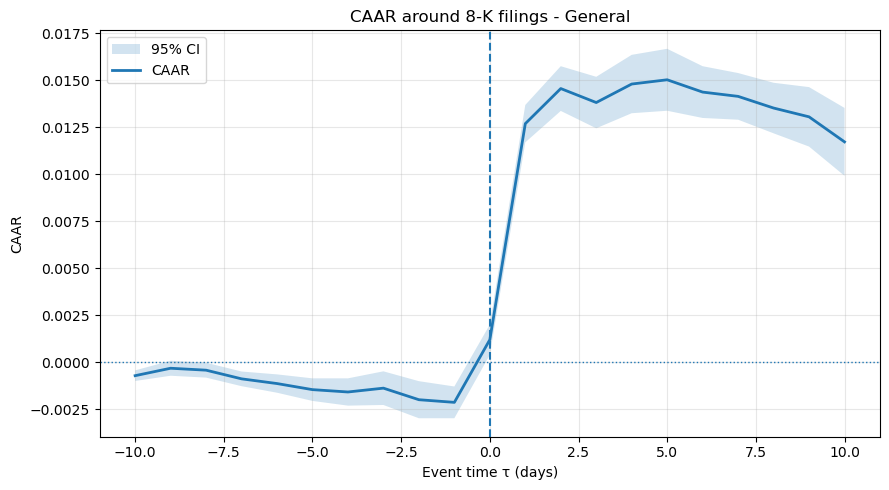

In [ ]:
df_events = df_8k_iti_filter.select(pl.col('date'), pl.col('permno')).unique()
df_events = df_events.rename({'date': 'event_date'})

general_results = event_study(
    df_events=df_events.to_pandas(),
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom')


caar_general = compute_caar_ci(general_results)
plot_caar_ci(caar_general, title='CAAR around 8-K filings - General')

**And let's do an event study on ITI**

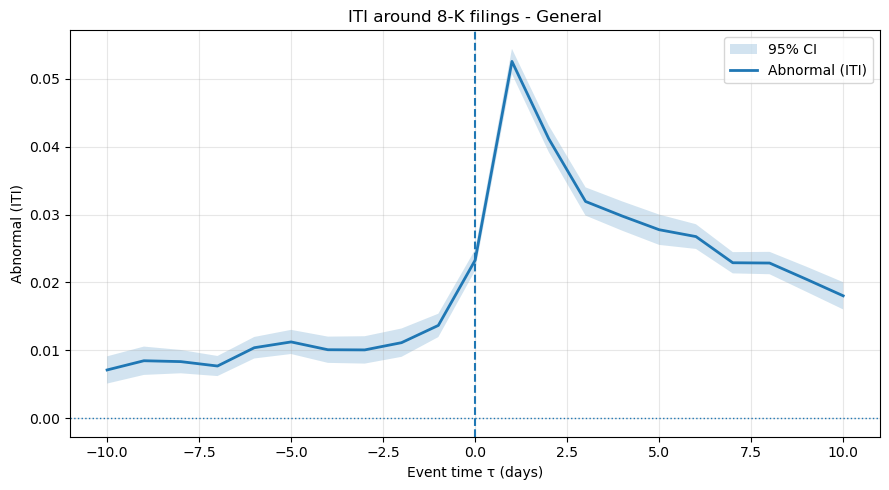

In [35]:
general_results_iti = event_study(
    df_events=df_events.to_pandas(),
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom',
    subject='ITI')


caar_general = compute_caar_ci(general_results_iti)
plot_caar_ci(caar_general, title='ITI around 8-K filings - General', subject ='ITI')

**Let's see the difference in distribution between high and low ITI**

In [36]:
# Compute mean ITI(13D) per permno
df_mean = (
    df_8k_iti_filter
    .group_by("permno")
    .agg(
        pl.col("ITI(13D)").mean().alias("mean_ITI_13D")
    )
)

# Select the top 10%
quantile_90 = df_mean.select(
    pl.col("mean_ITI_13D").quantile(0.9)
).item()

df_top10 = df_mean.filter(
    pl.col("mean_ITI_13D") >= quantile_90
)

**Filing date vs Report date for high ITI**

In [37]:
# Compute mean ITI(13D) per permno
df_mean = (
    df_8k_iti_filter
    .group_by("permno")
    .agg(
        pl.col("ITI(13D)").mean().alias("mean_ITI_13D")
    )
)
# Select the top 10%
quantile_90 = df_mean.select(
    pl.col("mean_ITI_13D").quantile(0.9)
).item()

df_top10 = df_mean.filter(
    pl.col("mean_ITI_13D") >= quantile_90
)

permno_top10 = df_top10.select(pl.col("permno")).to_series().to_list()

df_top10 = df_8k_iti_filter.filter(pl.col("permno").is_in(permno_top10))


event_study = df_top10.filter(pl.col('days_between_report_and_filing').is_not_null())


event_study = event_study.with_columns((pl.col('date') + pl.duration(days='days_between_report_and_filing')).alias('filing_date'))


event_study_filing = event_study.select(["permno", "filing_date"]).unique()
event_study_report = event_study.select(["permno", "date"]).unique()


df_events_top10 = event_study_filing.rename({'filing_date': 'event_date'})
df_events_report = event_study_report.rename({'date': 'event_date'})


from src.utils.event_study import event_study
results = event_study(
    df_events=df_events_top10.to_pandas(),
    window_before=10,
    window_after=10,
    est_window=750,
    gap=30,
    min_obs=500,
    market_model='fama-mom'
)


result_report = event_study(
    df_events=df_events_report.to_pandas(),
    window_before=10,
    window_after=10,
    est_window=750,
    gap=30,
    min_obs=500,
    market_model='fama-mom'
)

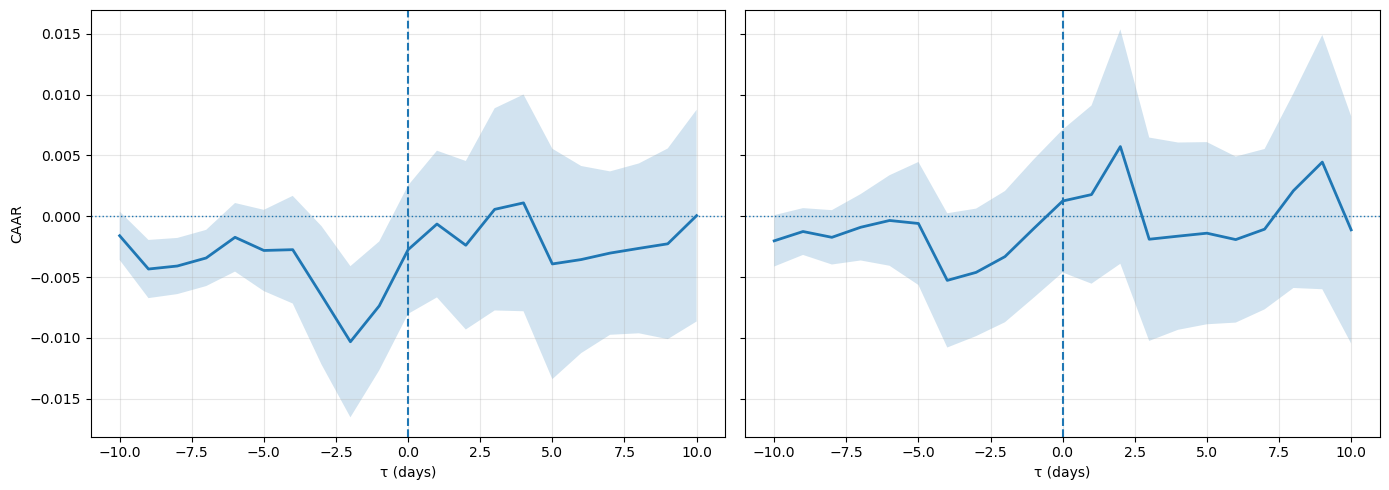

In [39]:
from src.utils.event_study import  plot_x_vs_y
plot_x_vs_y(result_report, results)

**Can we compare low and high ITI ?**

**HIGH and LOW ITI**

In [40]:
# Compute mean ITI per permno
df_mean = (
    df_8k_iti_filter
    .group_by("permno")
    .agg(
        pl.col("ITI(13D)").mean().alias("mean_ITI_13D")
    )
)

# Select the top 10%
quantile_90 = df_mean.select(
    pl.col("mean_ITI_13D").quantile(0.9)
).item()

df_top10 = df_mean.filter(
    pl.col("mean_ITI_13D") >= quantile_90
)

permno_top10 = df_top10.select(pl.col("permno")).to_series().to_list()

df_top10 = df_8k_iti_filter.filter(pl.col("permno").is_in(permno_top10))

In [41]:
# Select the bottom 10%
quantile_10 = df_mean.select(
    pl.col("mean_ITI_13D").quantile(0.1)
).item()

df_bottom10 = df_mean.filter(
    pl.col("mean_ITI_13D") <= quantile_10
)
    
permno_bottom10 = df_bottom10.select(pl.col("permno")).to_series().to_list()

df_bottom10 = df_8k_iti_filter.filter(pl.col("permno").is_in(permno_bottom10))

In [42]:
event_study_bottom10 = df_bottom10.filter(pl.col('days_between_report_and_filing').is_not_null())
event_study_top10 = df_top10.filter(pl.col('days_between_report_and_filing').is_not_null())

event_study_top10 = event_study_top10.select(["permno", "date"]).unique()
event_study_bottom10 = event_study_bottom10.select(["permno", "date"]).unique()

df_events_top10 = event_study_top10.rename({'date': 'event_date'})
df_events_bottom10 = event_study_bottom10.rename({'date': 'event_date'})

In [43]:
result_top10 = event_study(
    df_events=df_events_top10.to_pandas(),
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom'
)
result_bottom10 = event_study(
    df_events=df_events_bottom10.to_pandas(),
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom'
)

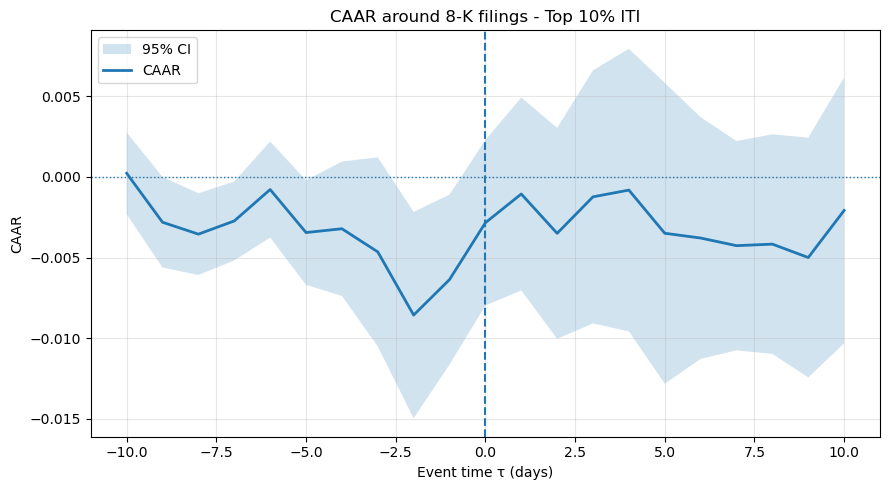

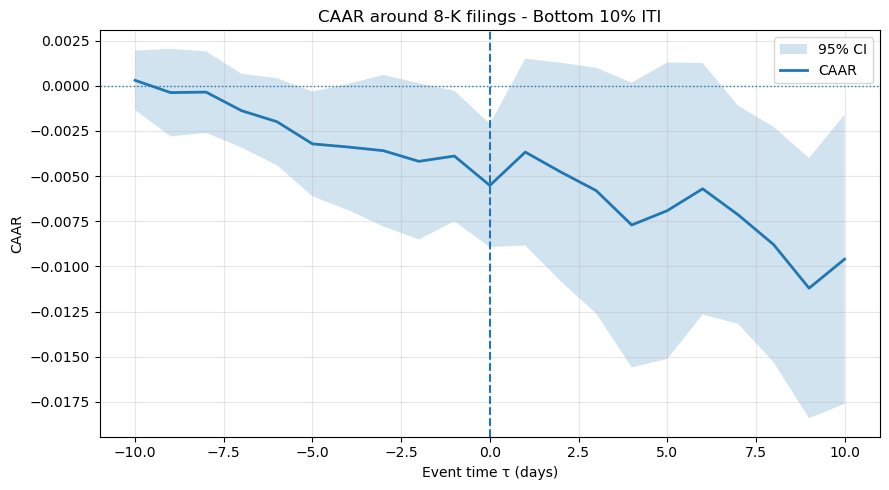

In [44]:
from src.utils.event_study import compute_caar_ci, plot_caar_ci

agg_top10 = compute_caar_ci(result_top10)
agg_bottom10 = compute_caar_ci(result_bottom10)

plot_caar_ci(agg_top10, title='CAAR around 8-K filings - Top 10% ITI')
plot_caar_ci(agg_bottom10, title='CAAR around 8-K filings - Bottom 10% ITI')

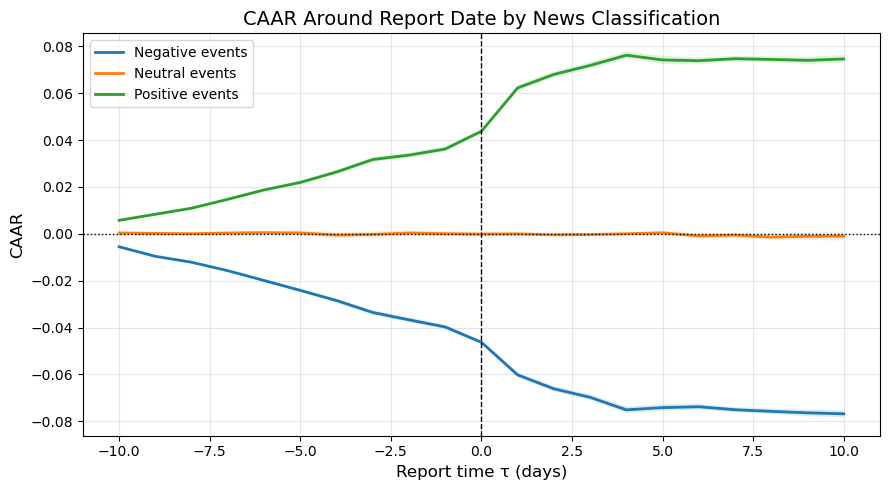

In [45]:
# Filter based on day 4 
window = general_results.query("tau <= 4")

car_event = (
    window.groupby(['permno','event_date'])['AR']
          .sum()
          .reset_index()
          .rename(columns={'AR': 'CAR_m1_p1'})
)

results_classified = general_results.merge(car_event,
                                          on=['permno','event_date'],
                                          how='left')

def classify(x):
    if x > 0.005:     
        return "Positive"
    elif x < -0.005:  
        return "Negative"
    else:
        return "Neutral"

results_classified['news_sign'] = results_classified['CAR_m1_p1'].apply(classify)

plt.figure(figsize=(9,5))

for label, df_sub in results_classified.groupby('news_sign'):


    agg = compute_caar_ci(df_sub)

    # Confidence interval
    plt.fill_between(
        agg['tau'],
        agg['ci_low'],
        agg['ci_high'],
        alpha=0.15
    )

    # CAAR line
    plt.plot(
        agg['tau'],
        agg['mean_CAR'],
        linewidth=2,
        label=f"{label} events"
    )

# Vertical event line
plt.axvline(0, linestyle='--', color='black', linewidth=1)

# Horizontal zero line
plt.axhline(0, linestyle=':', color='black', linewidth=1)

# Labels and title
plt.xlabel("Report time τ (days)", fontsize=12)
plt.ylabel("CAAR", fontsize=12)
plt.title("CAAR Around Report Date by News Classification", fontsize=14)

# Grid
plt.grid(True, alpha=0.3)

# Legend
plt.legend()

plt.tight_layout()
plt.show()

We can take random dates with same stocks, see if conditional distribution is the same -> see if scale is the same

In [9]:
from src.utils.event_study import make_random_events

In [47]:
df_events_true = df_events.to_pandas().rename(columns={'date':'event_date'})
df_events_random = make_random_events(df_events_true,
                                      buffer_days=60,
                                      n_random_per_event=1)

In [48]:
df_events_random

,permno,event_date
0,88543,2006-02-10
1,85951,2014-03-03
2,18126,2020-09-04
3,14321,2015-04-09
4,89917,2005-06-01
...,...,...
63271,61955,2003-09-12
63272,87261,2004-12-13
63273,12559,2015-01-08
63274,11999,2014-09-11


In [49]:
general_results_placebo = event_study(
    df_events=df_events_random,
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom',
    subject='returns'
)

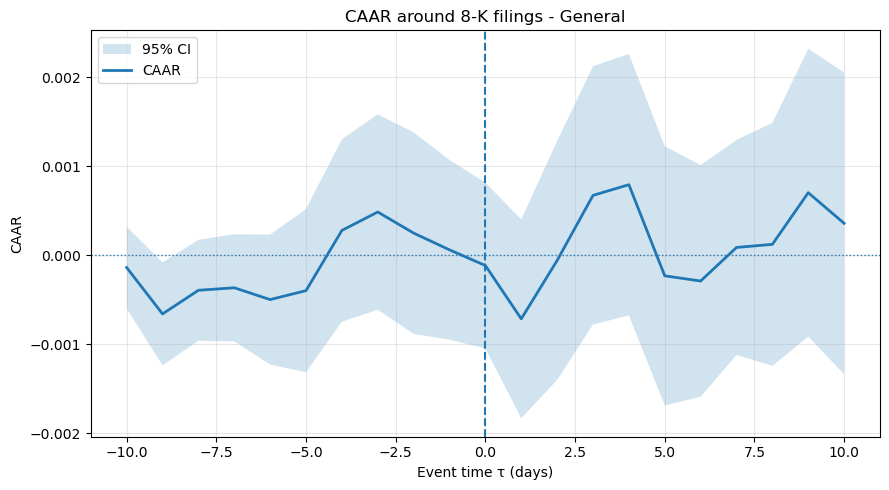

In [50]:
caar_general = compute_caar_ci(general_results_placebo)
plot_caar_ci(caar_general, title='CAAR around 8-K filings - General')

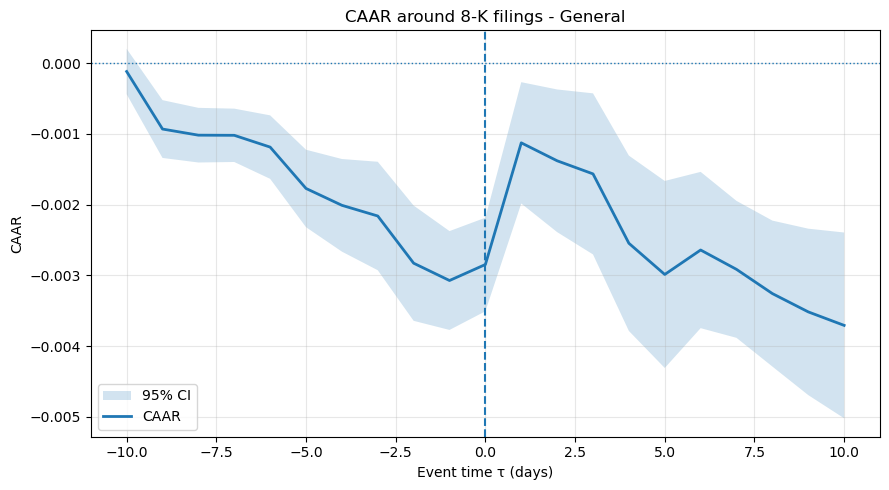

In [51]:
caar_general = compute_caar_ci(general_results)
plot_caar_ci(caar_general, title='CAAR around 8-K filings - General')

**Is scale different from different distributions for ITI ?**

In [55]:
general_results_placebo_iti = event_study(
    df_events=df_events_random,
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom',
    subject='ITI'
)

In [56]:
general_results_iti = event_study(
    df_events=df_events.to_pandas(),
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom',
    subject='ITI')

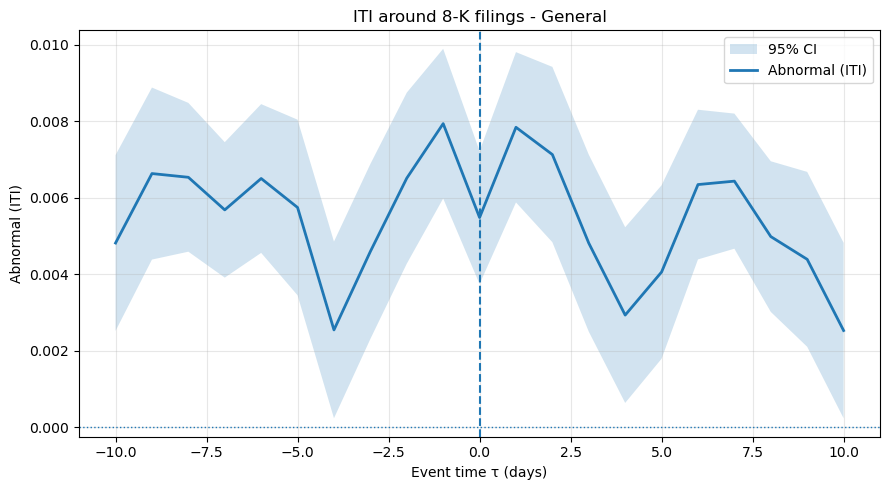

In [54]:
caar_general = compute_caar_ci(general_results_placebo_iti)
plot_caar_ci(caar_general, title='ITI around 8-K filings - General', subject ='ITI')

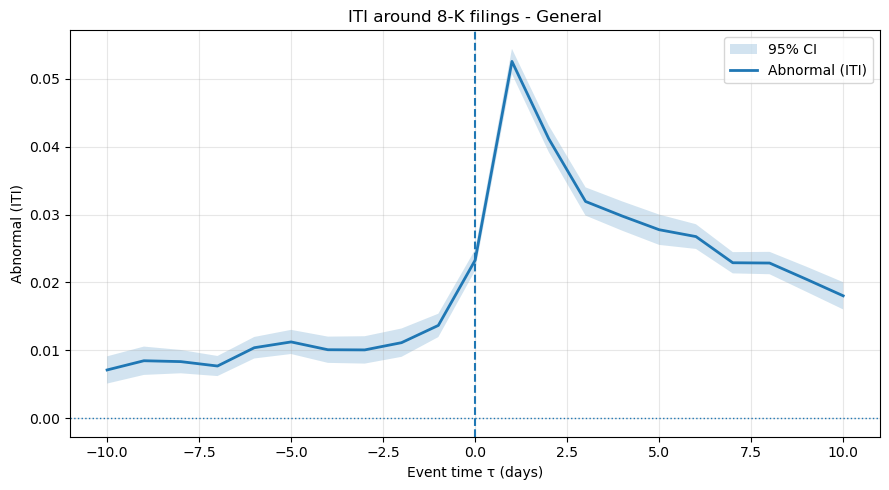

In [55]:
caar_general = compute_caar_ci(general_results_iti)
plot_caar_ci(caar_general, title='ITI around 8-K filings - General', subject ='ITI')

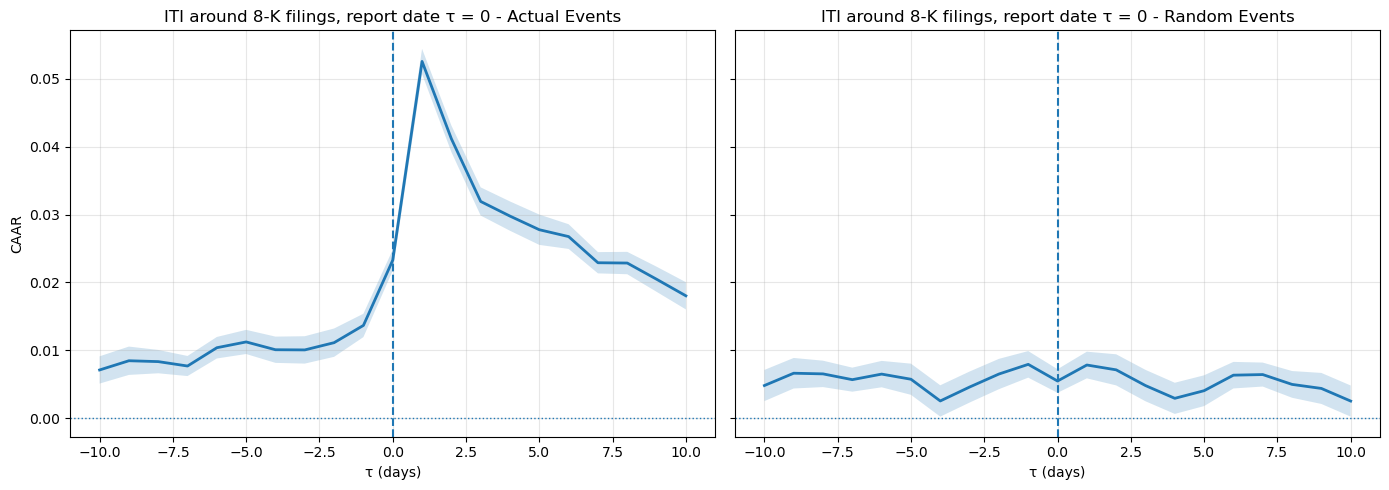

In [56]:
plot_x_vs_y(general_results_iti, general_results_placebo_iti, x_title='ITI around 8-K filings, report date τ = 0 - Actual Events', y_title='ITI around 8-K filings, report date τ = 0 - Random Events')

**Now let's try around filing date**

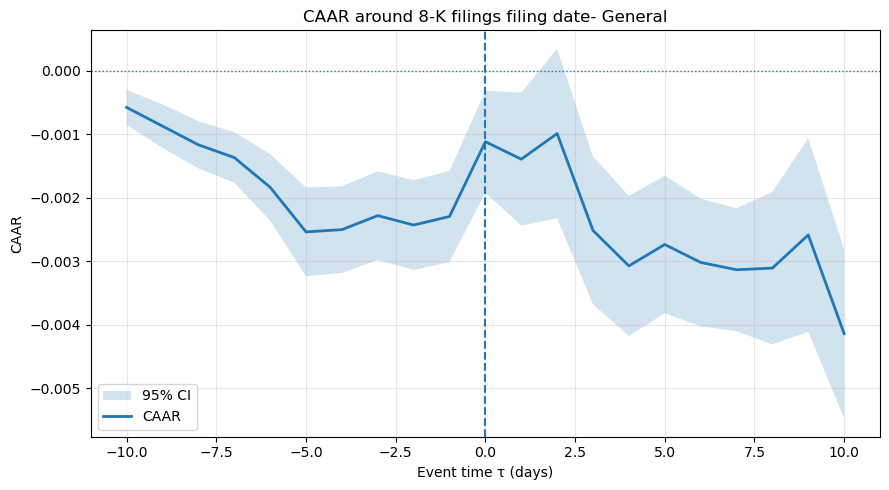

In [53]:
df_events_filing = df_8k_iti_filter.with_columns((pl.col('date') + pl.duration(days='days_between_report_and_filing')).alias('filing_date'))
df_events_filing = df_events_filing.rename({'filing_date': 'event_date'})

df_events_filing = df_events_filing.select(pl.col('event_date'), pl.col('permno')).unique()

general_results_filing = event_study(
    df_events=df_events_filing.to_pandas(),
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom')


caar_general_filing = compute_caar_ci(general_results_filing)
plot_caar_ci(caar_general_filing, title='CAAR around 8-K filings filing date- General')

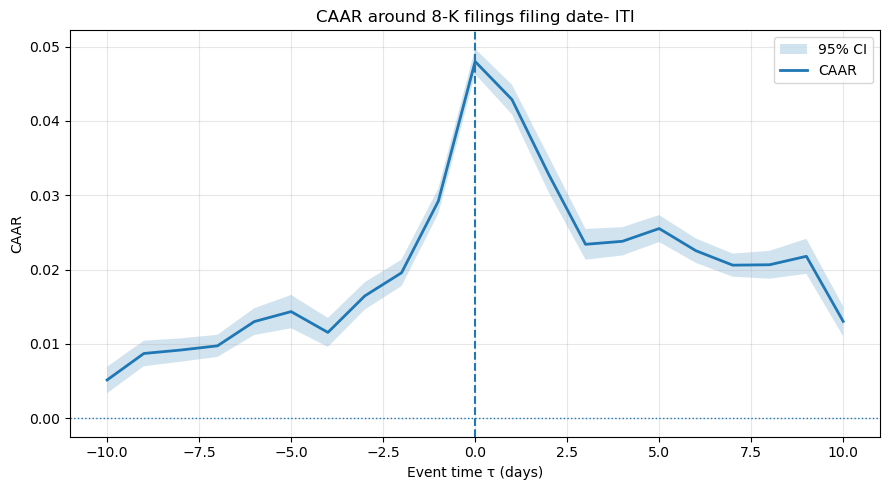

In [58]:
general_results_filing_iti = event_study(
    df_events=df_events_filing.to_pandas(),
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom',
    subject='ITI')
caar_general_filing_iti = compute_caar_ci(general_results_filing_iti)
plot_caar_ci(caar_general_filing_iti, title='CAAR around 8-K filings filing date- ITI')


In [54]:
df_events_random_filing = make_random_events(df_events_filing.to_pandas(),
                                      buffer_days=60,
                                      n_random_per_event=1)

general_results_placebo_iti_filing = event_study(
    df_events=df_events_random_filing,
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom',
    subject='ITI'
)


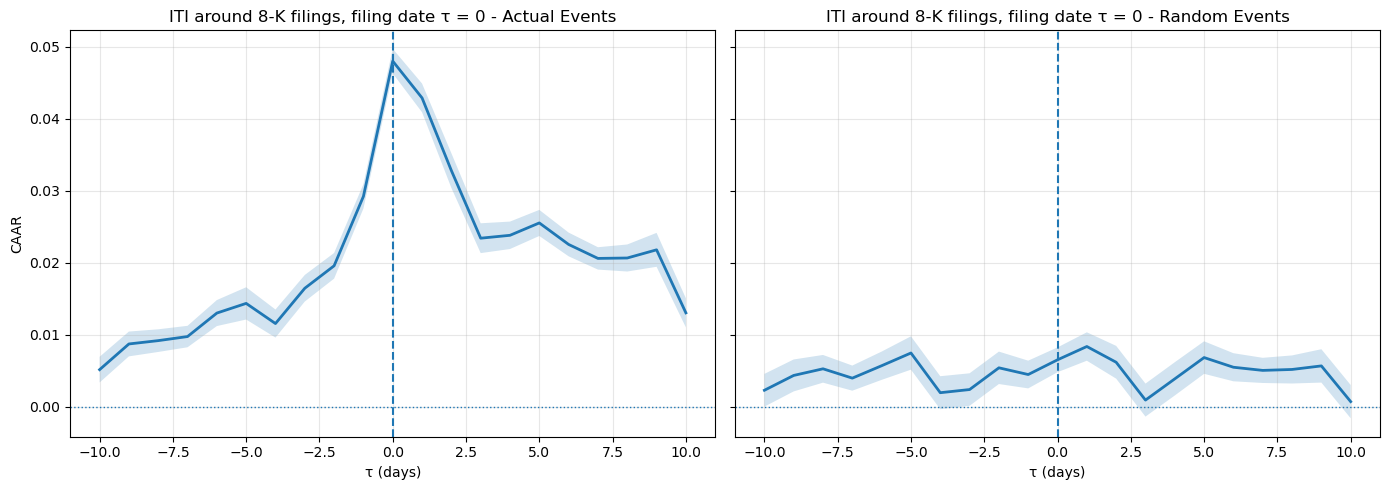

In [60]:
plot_x_vs_y(general_results_filing_iti, general_results_placebo_iti_filing, x_title='ITI around 8-K filings, filing date τ = 0 - Actual Events', y_title='ITI around 8-K filings, filing date τ = 0 - Random Events')

Try to filter by market cap

In [61]:
general_result_pl = pl.from_pandas(general_results)

In [62]:
general_result_pl = general_result_pl.with_columns(
    pl.col("event_date").cast(pl.Date)
)

merged = all_stocks.join(
    general_result_pl,
    left_on=["permno", "date"],
    right_on=["permno", "event_date"],
    how="right"
)

In [63]:
merged = merged.select(["permno", "date", "market_cap", "tau", "AR","CAR", "event_date"])

In [64]:
merged_pandas = merged.to_pandas()

In [65]:
merged_pandas

,permno,date,market_cap,tau,AR,CAR,event_date
0,10002,2004-02-02,154349250.0,-10,0.054703,0.054703,2004-02-12
1,10002,2004-02-03,154349250.0,-9,0.012908,0.067611,2004-02-12
2,10002,2004-02-04,154349250.0,-8,0.003352,0.070963,2004-02-12
3,10002,2004-02-05,154349250.0,-7,0.024181,0.095144,2004-02-12
4,10002,2004-02-06,154349250.0,-6,-0.027598,0.067545,2004-02-12
...,...,...,...,...,...,...,...
857677,93428,2014-11-10,634042070.0,6,-0.006769,0.267332,2014-11-04
857678,93428,2014-11-11,634042070.0,7,-0.016357,0.250975,2014-11-04
857679,93428,2014-11-12,634042070.0,8,-0.000692,0.250283,2014-11-04
857680,93428,2014-11-13,634042070.0,9,0.013352,0.263634,2014-11-04


In [66]:
top_10_market_cap = merged_pandas["market_cap"].quantile(0.9)

In [67]:
top_10_market_cap_events = merged_pandas[merged_pandas["market_cap"] >= top_10_market_cap]

In [68]:
top_10_market_cap_events

,permno,date,market_cap,tau,AR,CAR,event_date
1488,10078,2005-01-21,1.472747e+10,-10,-0.009596,-0.009596,2005-01-31
1489,10078,2005-01-24,1.472747e+10,-7,-0.004589,-0.014185,2005-01-31
1490,10078,2005-01-25,1.472747e+10,-6,0.006455,-0.007730,2005-01-31
1491,10078,2005-01-26,1.472747e+10,-5,-0.018134,-0.025863,2005-01-31
1492,10078,2005-01-27,1.472747e+10,-4,-0.009377,-0.035240,2005-01-31
...,...,...,...,...,...,...,...
857253,93422,2014-08-11,5.893691e+09,5,0.004121,0.031115,2014-08-06
857254,93422,2014-08-12,5.893691e+09,6,-0.005205,0.025910,2014-08-06
857255,93422,2014-08-13,5.893691e+09,7,-0.001169,0.024741,2014-08-06
857256,93422,2014-08-14,5.893691e+09,8,-0.005725,0.019016,2014-08-06


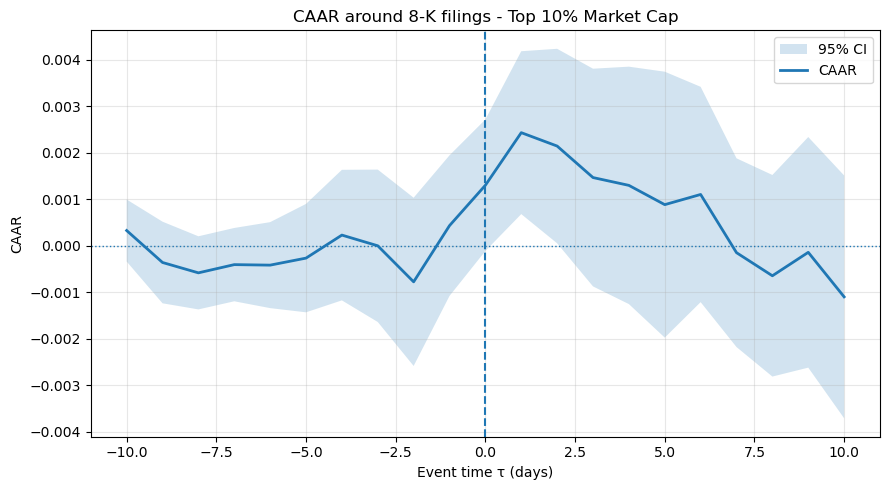

In [69]:
caar_top_market = compute_caar_ci(top_10_market_cap_events)
plot_caar_ci(caar_top_market, title='CAAR around 8-K filings - Top 10% Market Cap')

Try again to differentiate positve, negative etc

In [70]:


car_event = (
    window.groupby(['permno','event_date'])['AR']
          .sum()
          .reset_index()
          .rename(columns={'AR': 'CAR_m1_p1'})
)


In [73]:
import pandas as pd

# ============================================================
# STEP 1 — Compute CAR in the reaction window [0, +1]
# ============================================================

def compute_car_reaction(results, t1=0, t2=1):
    """
    Computes CAR over the narrow reaction window [t1, t2] for each
    (permno, event_date). Returns a DataFrame with CAR_reaction.
    """
    # Select event window rows
    w = results.query("tau >= @t1 & tau <= @t2")

    # Sum ARs for CAR
    car = (
        w.groupby(['permno', 'event_date'])['AR']
         .sum()
         .reset_index()
         .rename(columns={'AR': 'CAR_reaction'})
    )

    return car


# Compute CARs in reaction window
car_df = compute_car_reaction(general_results, t1=0, t2=1)


# ============================================================
# STEP 2 — Compute quantile thresholds
# ============================================================

q10 = car_df['CAR_reaction'].quantile(0.10)
q90 = car_df['CAR_reaction'].quantile(0.90)


# ============================================================
# STEP 3 — Classification rule
# ============================================================

def classify_event(x):
    """
    Classify event according to CAR_reaction quantiles.
    """
    if x >= q90:
        return "Positive"
    elif x <= q10:
        return "Negative"
    else:
        return "Neutral"


car_df['news_sign'] = car_df['CAR_reaction'].apply(classify_event)


# ============================================================
# STEP 4 — Merge classification back into original results
# ============================================================

general_results_classified = general_results.merge(
    car_df[['permno', 'event_date', 'news_sign']],
    on=['permno', 'event_date'],
    how='left'
)
print(general_results_classified)
print("Classification complete.")
print(general_results_classified[['permno', 'event_date', 'tau', 'news_sign']].head())

        permno event_date       date  tau       ret   exp_ret        AR  \
0        10002 2004-02-12 2004-02-02  -10  0.052762 -0.001941  0.054703   
1        10002 2004-02-12 2004-02-03   -9  0.012972  0.000064  0.012908   
2        10002 2004-02-12 2004-02-04   -8 -0.010477 -0.013829  0.003352   
3        10002 2004-02-12 2004-02-05   -7  0.029412  0.005231  0.024181   
4        10002 2004-02-12 2004-02-06   -6 -0.014286  0.013312 -0.027598   
...        ...        ...        ...  ...       ...       ...       ...   
857677   93428 2014-11-04 2014-11-10    6 -0.006795 -0.000026 -0.006769   
857678   93428 2014-11-04 2014-11-11    7 -0.015484  0.000873 -0.016357   
857679   93428 2014-11-04 2014-11-12    8  0.011339  0.012031 -0.000692   
857680   93428 2014-11-04 2014-11-13    9 -0.007233 -0.020585  0.013352   
857681   93428 2014-11-04 2014-11-14   10  0.001821  0.002287 -0.000466   

             CAR news_sign  
0       0.054703   Neutral  
1       0.067611   Neutral  
2       0.07

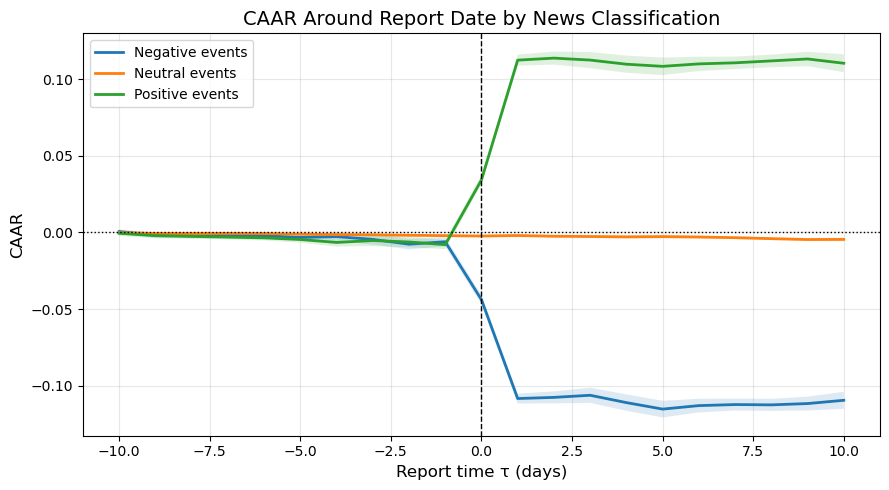

In [74]:

plt.figure(figsize=(9,5))

for label, df_sub in general_results_classified.groupby('news_sign'):


    agg = compute_caar_ci(df_sub)

    # Confidence interval
    plt.fill_between(
        agg['tau'],
        agg['ci_low'],
        agg['ci_high'],
        alpha=0.15
    )

    # CAAR line
    plt.plot(
        agg['tau'],
        agg['mean_CAR'],
        linewidth=2,
        label=f"{label} events"
    )

# Vertical event line
plt.axvline(0, linestyle='--', color='black', linewidth=1)

# Horizontal zero line
plt.axhline(0, linestyle=':', color='black', linewidth=1)

# Labels and title
plt.xlabel("Report time τ (days)", fontsize=12)
plt.ylabel("CAAR", fontsize=12)
plt.title("CAAR Around Report Date by News Classification", fontsize=14)

# Grid
plt.grid(True, alpha=0.3)

# Legend
plt.legend()

plt.tight_layout()
plt.show()

In [176]:
df_events_merged = df_8k_iti_filter.to_pandas().merge(
    car_df[['permno','event_date','CAR_reaction','news_sign']],
    right_on=['permno','event_date'],
    left_on=['permno','date'],
    how='left'
)

In [179]:
df_events_merged.dropna(subset=['news_sign'], inplace=True)

In [184]:
def map_item_category(item):
    if item in ['2.02','7.01','8.01']:
        return 'Financial'
    elif item in ['5.02','5.03']:
        return 'Governance'
    elif item in ['1.01','1.02','1.03']:
        return 'M&A / Contracts'
    elif item in ['1.04','8.01']:
        return 'Risk / Legal'
    else:
        return 'Other'

df_events_merged['item_cat'] = df_events_merged['items'].apply(map_item_category)

In [188]:
df_events_merged.groupby(['news_sign', 'item_cat'])['ITI(13D)'].describe()

count      mean       std       min       25%  \
news_sign item_cat                                                           
Negative  Financial         1361.0  0.313154  0.180522  0.008562  0.178154   
          Governance        1357.0  0.299398  0.165486  0.009241  0.170369   
          M&A / Contracts    443.0  0.292456  0.167784  0.032477  0.166904   
          Other            15012.0  0.314933  0.183248  0.002263  0.176546   
          Risk / Legal         7.0  0.433957  0.169140  0.167409  0.354775   
Neutral   Financial         2130.0  0.305612  0.168591  0.010456  0.179463   
          Governance        2187.0  0.283552  0.155698  0.000797  0.166412   
          M&A / Contracts    769.0  0.281720  0.158739  0.016796  0.161482   
          Other            19044.0  0.296173  0.168576  0.005838  0.169657   
          Risk / Legal         1.0  0.315459       NaN  0.315459  0.315459   
Positive  Financial         1272.0  0.307783  0.177940  0.017507  0.179470   
          Governance        1437.0  0.302326  0.163672  0.006361  0.175816   
          M&A / Contracts    414.0  0.295431  0.157136  0.022235  0.183138   
          Other            15055.0  0.317805  0.182472  0.003220  0.181959   
          Risk / Legal         2.0  0.321627  0.237789  0.153485  0.237556   

                                50%       75%       max  
news_sign item_cat                                       
Negative  Financial        0.278152  0.411696  0.933941  
          Governance       0.276551  0.398937  0.947706  
          M&A / Contracts  0.258201  0.390742  0.972576  
          Other            0.279618  0.421334  0.990136  
          Risk / Legal     0.486944  0.530386  0.613020  
Neutral   Financial        0.276204  0.406238  0.979518  
          Governance       0.259069  0.368837  0.969951  
          M&A / Contracts  0.253175  0.376866  0.907342  
          Other            0.265597  0.394212  0.996051  
          Risk / Legal     0.315459  0.315459  0.315459  
Positive  Financial        0.277933  0.399316  0.999231  
          Governance       0.271687  0.396594  0.945183  
          M&A / Contracts  0.272337  0.382764  0.888632  
          Other            0.286113  0.417615  0.999844  
          Risk / Legal     0.321627  0.405698  0.489769

In [189]:
q90 = df_events_merged['ITI(13D)'].quantile(0.9)
df_events_merged['high_iti'] = (df_events_merged['ITI(13D)'] >= q90).astype(int)

In [190]:
pd.crosstab(df_events_merged['news_sign'], df_events_merged['high_iti'], normalize='columns')

high_iti,0,1
news_sign,,
Negative,0.295135,0.344298
Neutral,0.405063,0.333719
Positive,0.299802,0.321983


In [191]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# -----------------------------------------------------
# Create dependent variable: 1 if Negative event
# -----------------------------------------------------
df_reg = df_events_merged.copy()
df_reg['is_negative'] = (df_reg['news_sign'] == 'Negative').astype(int)

# -----------------------------------------------------
# Make item_cat a categorical variable
# -----------------------------------------------------
df_reg['item_cat'] = df_reg['item_cat'].astype('category')

# -----------------------------------------------------
# Logistic regression:
# is_negative ~ ITI + item category fixed effects
# -----------------------------------------------------

model = smf.logit("is_negative ~ Q('ITI(13D)') + C(item_cat)", data=df_reg).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.610698
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_negative   No. Observations:                60491
Model:                          Logit   Df Residuals:                    60485
Method:                           MLE   Df Model:                            5
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                0.001021
Time:                        22:07:40   Log-Likelihood:                -36942.
converged:                       True   LL-Null:                       -36979.
Covariance Type:            nonrobust   LLR p-value:                 7.315e-15
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.0046      0.036    -28.156     

In [193]:
import numpy as np
import pandas as pd

# Range of ITI from 0 to 1 (you can adjust)
iti_grid = np.linspace(df_reg["ITI(13D)"].min(),
                       df_reg["ITI(13D)"].max(),
                       200)

# Hold item category fixed at the reference category (first alphabetically)
ref_cat = df_reg['item_cat'].cat.categories[0]

df_pred = pd.DataFrame({
    'ITI(13D)': iti_grid,
    'item_cat': ref_cat
})

df_pred['predicted_prob'] = model.predict(df_pred)

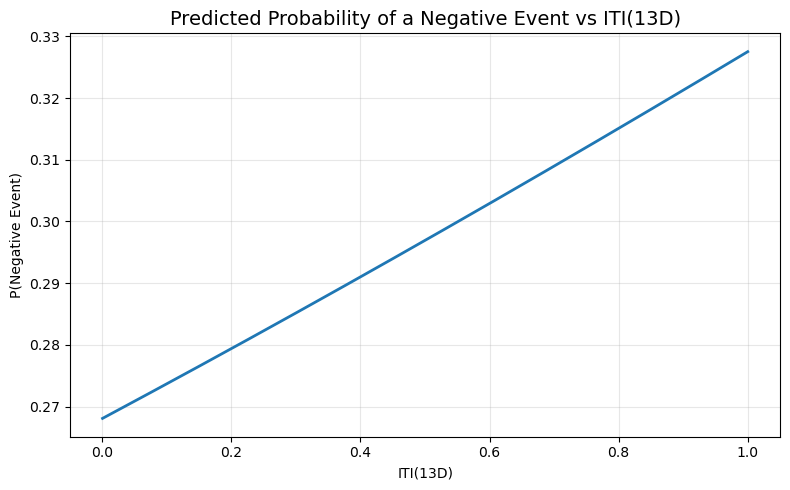

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_pred, x='ITI(13D)', y='predicted_prob', linewidth=2)

plt.title("Predicted Probability of a Negative Event vs ITI(13D)", fontsize=14)
plt.xlabel("ITI(13D)")
plt.ylabel("P(Negative Event)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

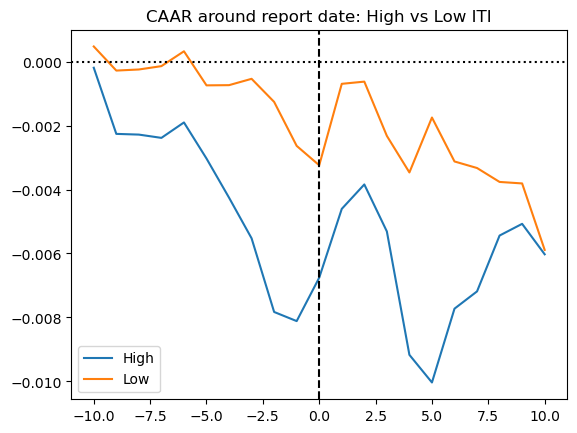

In [196]:
# découpe high / low ITI (top / bottom 10%)
q10 = df_events_merged['ITI(13D)'].quantile(0.10)
q90 = df_events_merged['ITI(13D)'].quantile(0.90)

df_events_merged['ITI_group'] = 'Middle'
df_events_merged.loc[df_events_merged['ITI(13D)'] <= q10, 'ITI_group'] = 'Low'
df_events_merged.loc[df_events_merged['ITI(13D)'] >= q90, 'ITI_group'] = 'High'

# merge ce groupe dans les résultats d’event study (report)
general_results_report_iti = general_results.merge(
    df_events_merged[['permno','event_date','ITI_group']],
    on=['permno','event_date'],
    how='left'
)

# CAAR par groupe
for label, df_sub in general_results_report_iti.query("ITI_group != 'Middle'").groupby('ITI_group'):
    agg = compute_caar_ci(df_sub)
    plt.plot(agg['tau'], agg['mean_CAR'], label=label)
plt.axvline(0, ls='--', c='k')
plt.axhline(0, ls=':', c='k')
plt.legend(); plt.title("CAAR around report date: High vs Low ITI"); plt.show()

**Per item analysis**

In [ ]:
filtered_items = df_8k_iti_filter.group_by('items').len().sort(by='len', descending=True).top_k(k=10, by = 'len')
df_8k_iti_filter_items = df_8k_iti_filter.filter(pl.col('items').is_in(filtered_items.select('items').to_series().to_list()))

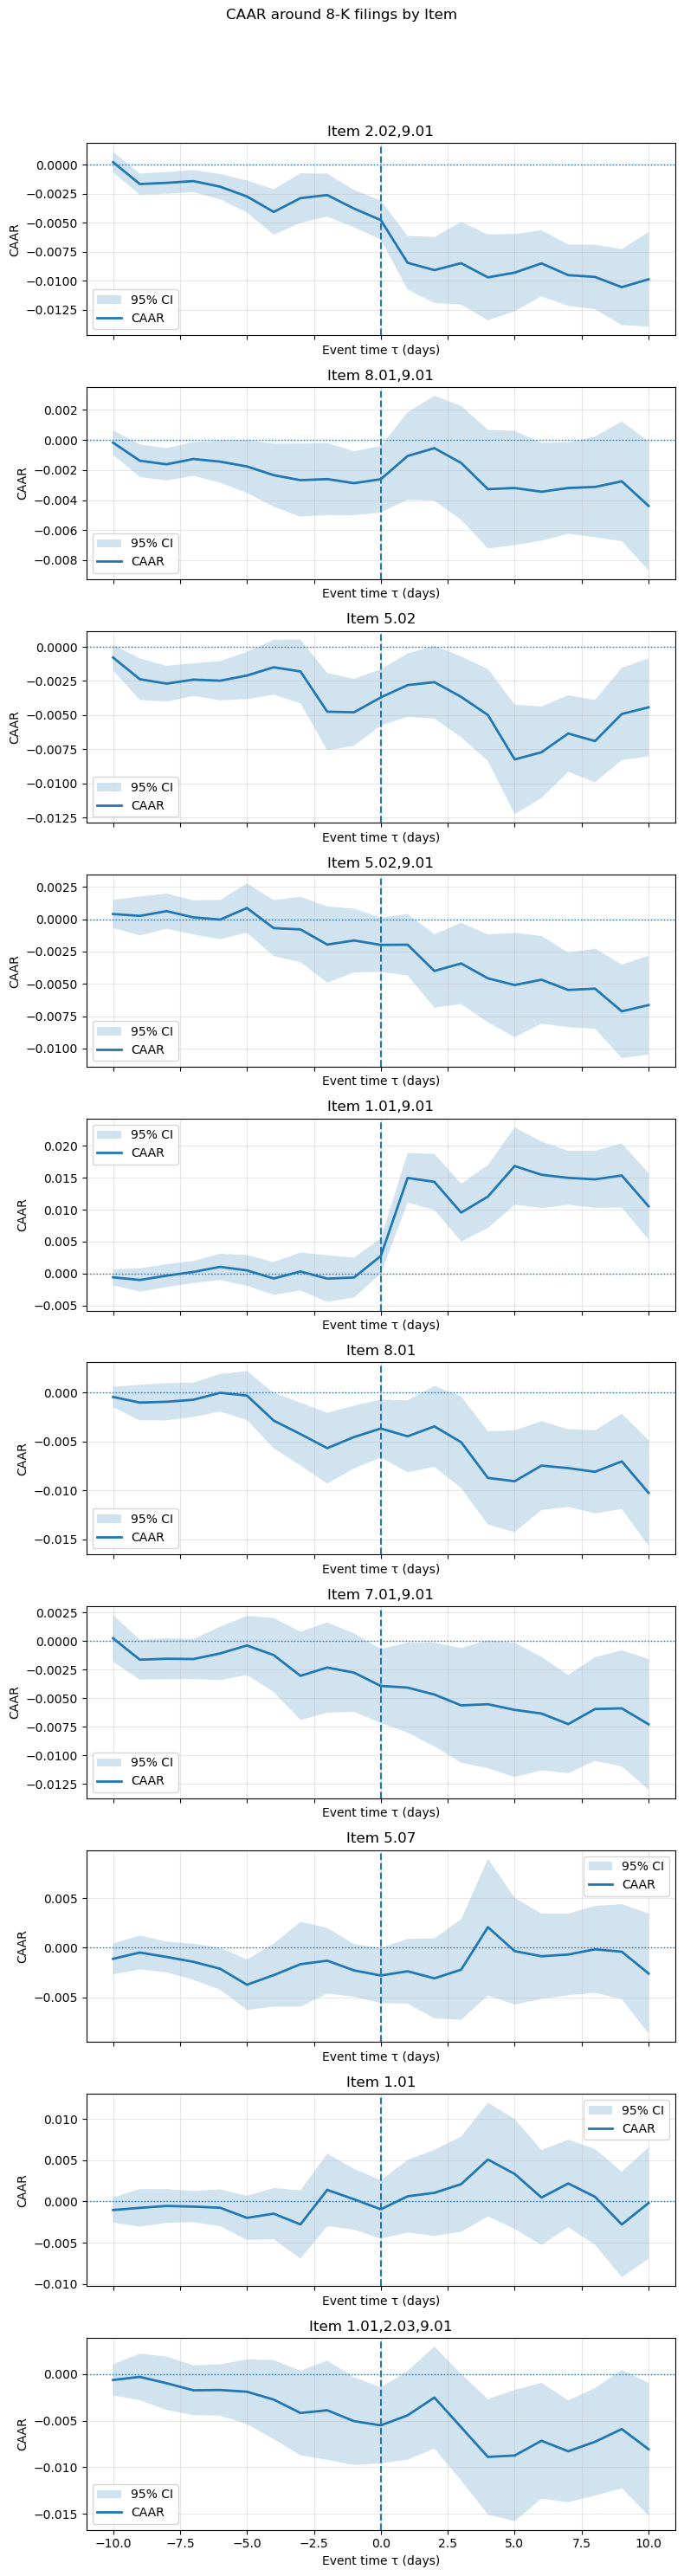

In [31]:
import matplotlib.pyplot as plt

items = filtered_items.select('items').to_series().to_list()

# Create one subplot per item
n_items = len(items)
fig, axes = plt.subplots(
    nrows=n_items,
    ncols=1,
    sharex=True,
    figsize=(8, 3 * n_items)
)

# If there is only one item, axes is not a list; make it iterable
if n_items == 1:
    axes = [axes]

for ax, item in zip(axes, items):
    df_item = df_8k_iti_filter_items.filter(pl.col('items') == item)

    df_events_item = (
        df_item
        .select(pl.col('date'), pl.col('permno'))
        .unique()
        .rename({'date': 'event_date'})
    )

    results_item = event_study(
        df_events=df_events_item.to_pandas(),
        window_before=10,
        window_after=10,
        est_window=500,
        gap=30,
        min_obs=250,
        market_model='fama-mom'
    )

    caar_item = compute_caar_ci(results_item)

    # New: pass the axis to the plotting function
    plot_caar_ci(caar_item, title=f'Item {item}', ax=ax)

# Global title and layout
fig.suptitle('CAAR around 8-K filings by Item', y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**VOL STUDY**

In [11]:
general_results_abs_return = event_study(
    df_events=df_events.to_pandas(),
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom',
    subject='abs returns'
)

df_events_true = df_events.to_pandas().rename(columns={'date':'event_date'})
df_events_random = make_random_events(df_events_true,
                                      buffer_days=60,
                                      n_random_per_event=1)

general_results_placebo_abs_return = event_study(
    df_events=df_events_random,
    window_before=10,
    window_after=10,
    est_window=500,
    gap=30,
    min_obs=250,
    market_model='fama-mom',
    subject='abs returns'
)

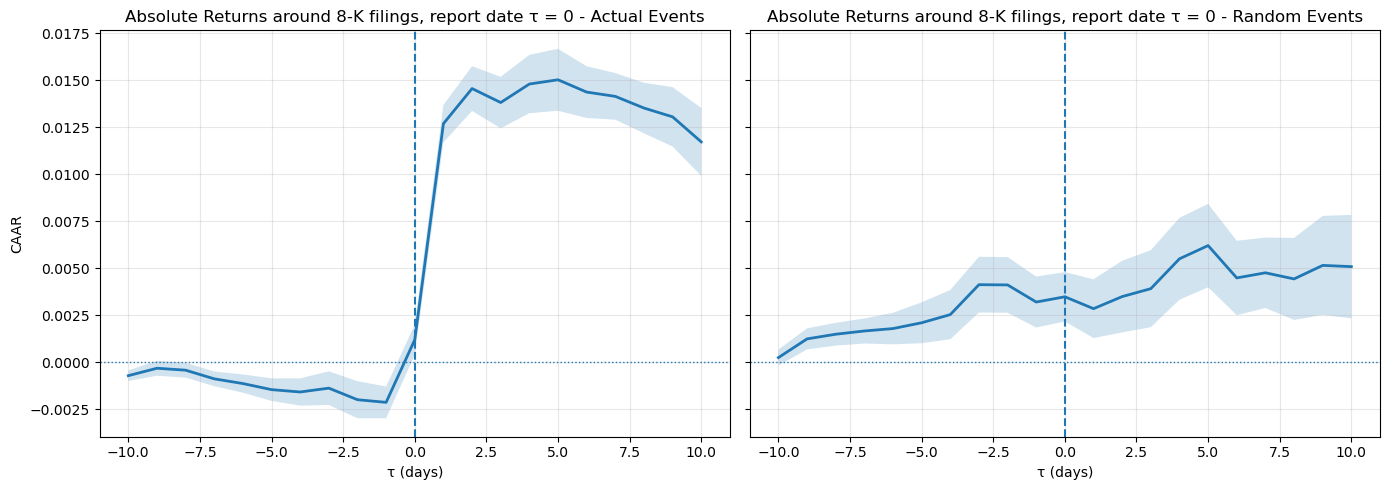

In [52]:
plot_x_vs_y(general_results_abs_return, general_results_placebo_abs_return, x_title='Absolute Returns around 8-K filings, report date τ = 0 - Actual Events', y_title='Absolute Returns around 8-K filings, report date τ = 0 - Random Events')

In [ ]:
general_results_iti.rename(columns={'AR':'ITI_AR'}, inplace=True)
general_results_placebo_iti.rename(columns={'AR':'ITI_AR'}, inplace=True)

In [ ]:
merged_df = general_results_abs_return.merge(
    general_results_iti,
    on=['permno','event_date','tau'],
    how = 'inner')
merged_df_placebo = general_results_placebo_abs_return.merge(
    general_results_placebo_iti,
    on=['permno','event_date','tau'],
    how = 'inner')

In [ ]:
corr_tau = (
    merged_df.groupby("tau")[["AR", "ITI_AR"]]
             .corr()
             .iloc[0::2, -1]        
             .reset_index()
             .rename(columns={"ITI_AR": "corr"})
)

corr_tau = corr_tau[['tau', 'corr']]   

In [59]:
corr_tau_placebo = (
    merged_df_placebo.groupby("tau")[["AR", "ITI_AR"]]
             .corr()
             .iloc[0::2, -1]        
             .reset_index()
             .rename(columns={"ITI_AR": "corr"})
)

corr_tau_placebo = corr_tau_placebo[['tau', 'corr']]   

In [47]:
corr_tau.rename(columns={"ITI_AR": "corr"}, inplace=True)

In [60]:
corr_tau_placebo.rename(columns={"ITI_AR": "corr"}, inplace=True)

In [49]:
import pandas as pd
corr_matrix = corr_tau.pivot_table(columns='tau', values='corr')
corr_matrix.index = ["corr(ITI, |AR|)"]

In [61]:
import pandas as pd
corr_matrix_placebo = corr_tau_placebo.pivot_table(columns='tau', values='corr')
corr_matrix_placebo.index = ["corr(ITI, |AR|)"]

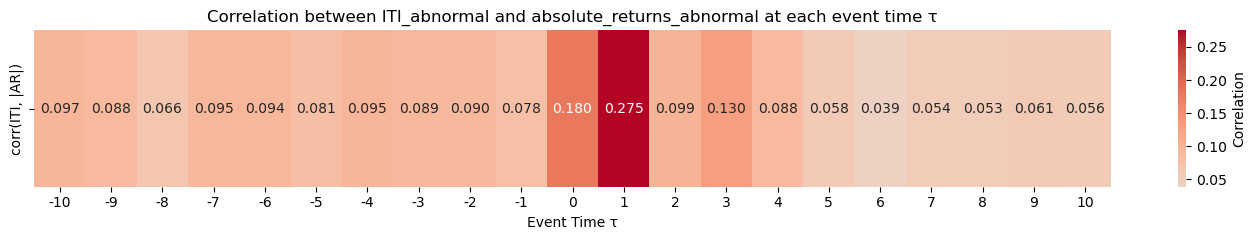

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 2.5))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    cbar_kws={'label': 'Correlation'}
)

plt.title("Correlation between ITI_abnormal and absolute_returns_abnormal at each event time τ")
plt.xlabel("Event Time τ")
plt.ylabel("")
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 2.5))
sns.heatmap(
    corr_matrix_placebo,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    cbar_kws={'label': 'Correlation'}
)

plt.title("Correlation between ITI_abnormal and absolute_returns_abnormal at each event time τ")
plt.xlabel("Event Time τ")
plt.ylabel("")
plt.tight_layout()
plt.show()

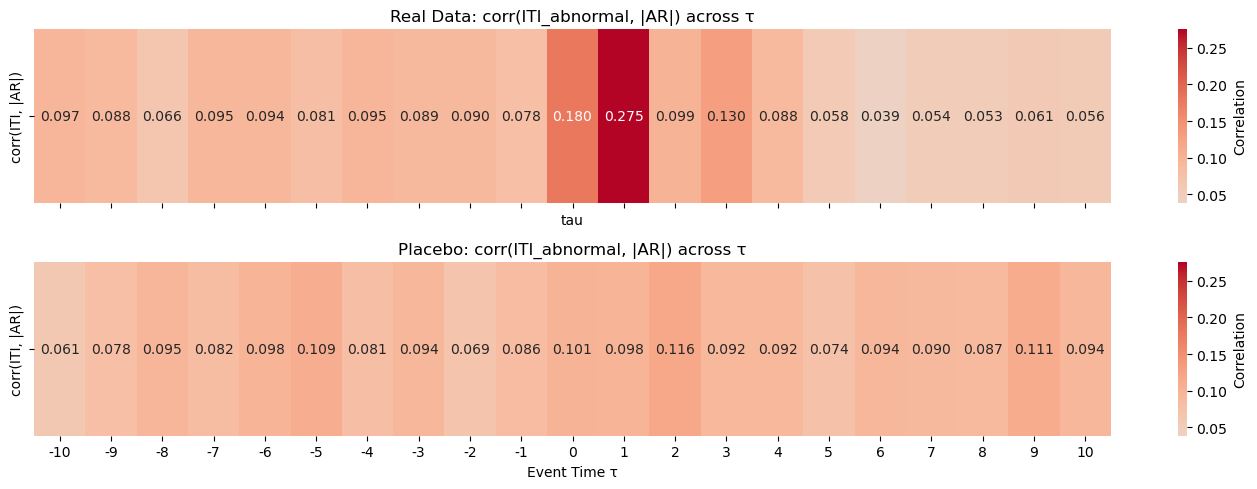

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- shared color scale between the two heatmaps ---
vmin = min(corr_matrix.min().min(), corr_matrix_placebo.min().min())
vmax = max(corr_matrix.max().max(), corr_matrix_placebo.max().max())

fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=True)

# --- REAL DATA HEATMAP ---
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    vmin=vmin, vmax=vmax,
    cbar=True,
    cbar_kws={'label': 'Correlation'},
    ax=axes[0]
)
axes[0].set_title("Real Data: corr(ITI_abnormal, |AR|) across τ", fontsize=12)
axes[0].set_ylabel("")

# --- PLACEBO HEATMAP ---
sns.heatmap(
    corr_matrix_placebo,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    vmin=vmin, vmax=vmax,
    cbar=True,
    cbar_kws={'label': 'Correlation'},
    ax=axes[1]
)
axes[1].set_title("Placebo: corr(ITI_abnormal, |AR|) across τ", fontsize=12)
axes[1].set_xlabel("Event Time τ")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()